# Goal

This notebook checks model generalization performance on other dsets.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso_sz    = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

# Paths

In [2]:
import os

# Paths to (1) code (2) data
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

# stored code
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# stored data
label_src   = f"{data_src}/PitMRdata/samir_labels"
ABIDE_src   = f"{data_src}/PitMRdata/ABIDE"

# stored runs Tensorboard
run_src     = f"{data_src}/runs"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/PitMRdata/samir_labels"
ABIDE_src   = f"{data_src}/PitMRdata/ABIDE"

# dsets and metadata
dsetmd_src   = f"{data_src}/saved_dset_metadata"
dsets_src    = f"{data_src}/PitMRdata"

# key,val = dset_name, path to top level dir
dset_dict = {
    "ABIDE"                  : f"{dsets_src}/ABIDE",
    "ABVIB"                  : f"{dsets_src}/ABVIB/ABVIB",
    "ADNI1_Complete_1Yr_1.5T": f"{dsets_src}/ADNI/ADNI1_Complete_1Yr_1.5T/ADNI",
    "AIBL"                   : f"{dsets_src}/AIBL/AIBL",
    "ICMB"                   : f"{dsets_src}/ICMB/ICBM",
    "PPMI"                   : f"{dsets_src}/PPMI/PPMI",
}

# print
print("Folders in dset src: ", end=""); print(*os.listdir(dsets_src), sep=", ")

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in dset src: ABVIB_49_235.zip, AIBL_2-263.zip, ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, ICMB_1005-1297.zip, AIBL, CPTAC-GBM, PPMI_3107-3326.zip, ADNI1_002_0023.zip, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in data src: saved_landmarks, saved_models, sample_other_dsets, Labels, saved_dset_metadata, runs, saved_preds, PitMRdata
Folders in label src (data w labels): 50155-50212, PPMI_3107-3326, 50313-50372, 50213-50312, 50373-50453, 50002-50153, AIBL_2-263, ICMB_1005-1297, ADNI1_002_0023, ABVIB_49_235
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
# imports (# Piece)
from transforms import (
    AddChannel, Iso, 
    PadSz, ZScale, 
    GNoise, GBlur,
    RandBright, RandContrast, 
    RandDihedral, MattAff
)    
        
from condseg_transforms import (
    AddAtlas, IsoAtlas, 
    ZScaleAtlas, AddChAtlas, 
    MattAffAtlas, ConcatChannel)

from test_transforms import (
    IsoTest, PadSzTest,
    IsoAtlasTest, PadSzAtlasTest
)

from helpers.losses import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet

# Utilities
import os, sys, gc, time, pickle, glob
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from matplotlib import colors

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats, rm_prefix
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

# Labelled items

In [5]:
folders = sorted(Path(label_src).iterdir(), key=os.path.getmtime, reverse=True)
# print(*[Path(f).name for f in folders], sep="\n")

cross_lbl_folders = folders[:5]
abide_lbl_folders = folders[5:]

print("Cross", *cross_lbl_folders, sep="\n"); print("*"*50)
print("Abide", *abide_lbl_folders, sep="\n")

Cross
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/PPMI_3107-3326
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ICMB_1005-1297
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/AIBL_2-263
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ADNI1_002_0023
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ABVIB_49_235
**************************************************
Abide
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153


In [7]:
# Open matched segs = (seg_folder, mr_folder)
with open(f"{dsetmd_src}/first_100_matched_segs.txt", "r") as f:
    lst = f.read().splitlines()
    # str to tuple
    cross_seg_paths, cross_mr_paths = zip(*[eval(s) for s in lst])
    
# Get cross-dset data dict
cross_lbl_items = [(f"{mr}/las_n4.nii", f"{seg}/seg.pt") for mr, seg in zip(cross_mr_paths, cross_seg_paths)]

In [20]:
print(*cross_lbl_items[0], sep="\n")

/gpfs/data/oermannlab/private_data/DeepPit/sample_other_dsets/AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_no_n4.nii
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/AIBL_2-263/263/seg.pt


In [21]:
# Get ABIDE data dict
abide_data = {}
for folder in abide_lbl_folders: abide_data.update(get_data_dict_n4(folder))

# Convert data dict => items (path to MR, path to Segm tensor)
abide_lbl_items = list(abide_data.values())
print(f"Full lbl items: {len(abide_lbl_items)}")

# remove bad label 50132
abide_weird_lbls = [50132, 50403]
def is_weird(fn): return any([str(lbl) in fn for lbl in abide_weird_lbls])
   
abide_lbl_items = [o for o in abide_lbl_items if not is_weird(o[0])]
print(f"Removed {len(abide_weird_lbls)} weird, new total lbl items: {len(abide_lbl_items)}")

Full lbl items: 335
Removed 2 weird, new total lbl items: 333


In [22]:
print(*abide_lbl_items[0], sep="\n")

/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50385/MP-RAGE/2000-01-01_00_00_00.0/S164676/ABIDE_50385_MRI_MP-RAGE_br_raw_20120830175317987_S164676_I328686_corrected_n4.nii
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453/50385/seg.pt


# Items

In [23]:
is_items_lbl = True

items = [cross_lbl_items[i] for i in range(0,100,5)]
print(f"Cross label items: {len(items)}")


# pretty print
cross_mr_src = f"{data_src}/sample_other_dsets"
print(*[(mr[len(cross_mr_src)+1:],seg[len(label_src)+1:]) for mr,seg in items], sep=f"\n{'*'*100}\n")

Cross label items: 20
('AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_no_n4.nii', 'AIBL_2-263/263/seg.pt')
****************************************************************************************************
('AIBL/2/MPRAGE_ADNI_confirmed/2011-11-15_10_42_23.0/S235328/las_no_n4.nii', 'AIBL_2-263/2/seg.pt')
****************************************************************************************************
('AIBL/38/MPRAGE_ADNI_confirmed/2013-07-19_10_47_31.0/S782832/las_no_n4.nii', 'AIBL_2-263/38/seg.pt')
****************************************************************************************************
('AIBL/118/MPRAGE_ADNI_confirmed/2010-08-04_14_26_39.0/S104520/las_no_n4.nii', 'AIBL_2-263/118/seg.pt')
****************************************************************************************************
('ICMB/UCLA_1297/SAG_MPRAGE_8_CHANNEL/2006-01-31_17_05_45.0/S17045/las_no_n4.nii', 'ICMB_1005-1297/UCLA_1297/seg.pt')
***********************************************

# Model

In [24]:
model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
model_fns = [str(p) for p in model_fns]
print(*[model_fn[len(run_src):] for model_fn in model_fns], sep="\n")

/model_UNET3D_loss_perim_loss_iso_2mm_pad_144_144_144_bs_2_epochs_60_time_1626638418_Sun_Jul_07_2021_hr_16_min_00


In [25]:
#model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
model_fn   = Path(model_fns[0]).name
model_name = model_fn
test_fn    = model_name + "_test_items.pkl"

In [26]:
# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    res   = fn[start+len(prefix):end].split("_")

    if len(res) == 1: 
        try:
            return int(res[0])
        except:
            return res[0]

    # multiple results - list of ints or str
    try:
        return [int(x) for x in res]
    except:
        return "_".join(res)
    

model_type = get_param(model_fn, "model_", "_loss")
loss_type  = get_param(model_fn, "loss_", "_iso")
iso_sz     = get_param(model_fn, "iso_", "mm")
maxs       = get_param(model_fn, "pad_", "_bs")
bs         = get_param(model_fn, "bs_", "_epochs")
nepochs    = get_param(model_fn, "epochs_", "_time")

# print
print("Model name: ", model_name)
print(f"Model type: {model_type}. Loss type: {loss_type}. Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")

Model name:  model_UNET3D_loss_perim_loss_iso_2mm_pad_144_144_144_bs_2_epochs_60_time_1626638418_Sun_Jul_07_2021_hr_16_min_00
Model type: UNET3D. Loss type: perim_loss. Iso: 2. PadResize to: [144, 144, 144]. bs = 2. nepochs = 60.


# Transforms

In [27]:
if is_items_lbl:
    # tfms - no need for test
    if model_type.startswith("CONDSEG"):
        item_tfms  = [IsoAtlas(iso_sz), PadSzAtlas(maxs)]
        batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

    else:    
        item_tfms  = [Iso(iso_sz), PadSz(maxs)]
        batch_tfms = [ZScale(), AddChannel()]
else:
    # tfms - with test
    if model_type.startswith("CONDSEG"):
        item_tfms  = [AddAtlas(lbl_items), IsoAtlasTest(iso_sz), PadSzAtlasTest(maxs)]
        batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

    else:    
        item_tfms  = [IsoTest(iso_sz), PadSzTest(maxs)]
        batch_tfms = [ZScale(), AddChannel()]

# Dataloaders

In [28]:
# time it
start = time.time()

# tls
tls = TfmdLists(items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(items)} items")

Elapsed time: 25.06852960586548 s for 20 items


In [29]:
# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n = {len(items)}")

<class 'tuple'> torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
bs = 2, n_train = 20, n_valid = 0, n = 20


# Models

In [30]:
if model_type == "VNET":
    # https://docs.monai.io/en/latest/networks.html#vnet
    device = torch.device("cuda:0")
    model = VNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
    ).to(device)
    
elif model_type == "UNET3D":
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
elif model_type.startswith("CONDSEG"):
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=3,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif model_type == "OBELISKHYBRID":
    full_res = maxs
    model    = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
    
else:
    pass

# Loss

In [31]:
if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
    
elif loss_type == "perim_loss":
    loss_function = perim_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

In [32]:
print(model_type, loss_type)

UNET3D perim_loss


In [33]:
# if loss_type == "log_cosh_dice_loss":
#     loss_function = log_cosh_dice_loss
# elif loss_type == "DICE":
#     loss_function = dice_loss
# else:
#     loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

# Learner

In [34]:
import gc
gc.collect()

95

In [35]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{run_src}/{model_fn}/model")

In [36]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(dl=dls.train)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(items)} items.")

Elapsed: 12.77 s for 20 items.


In [37]:
print("Pred mask", predictions.shape, "Target (x = y = MR)", targets.shape)
print("Pred mask", predictions[0].shape, "Target", targets[0].shape)

Pred mask torch.Size([20, 2, 144, 144, 144]) Target (x = y = MR) torch.Size([20, 1, 144, 144, 144])
Pred mask torch.Size([2, 144, 144, 144]) Target torch.Size([1, 144, 144, 144])


In [38]:
start = time.time()

# get masks and probs
pred_masks = np.asarray(torch.argmax(predictions, dim=1).cpu())
pred_probs = np.asarray(predictions.softmax(1)[:,1].cpu())

# get predicted bboxs
pred_bboxs = [mask2bbox(pred_masks[i]) for i in range(len(pred_masks))]

elapsed = time.time() - start
print(f"Elapsed {elapsed:2f} s")

Elapsed 18.427390 s


In [54]:
def get_bbox_sz(bbox):    return np.prod([bbox[2*i+1]-bbox[2*i] for i in range(3)])
def get_bbox_sides(bbox): return [bbox[2*i+1]-bbox[2*i] for i in range(3)]
    
pred_bbox_szs = [get_bbox_sz(bbox) for bbox in pred_bboxs]

# sort by largest size
sorted_idxs = sorted(range(len(pred_bbox_szs)), key=lambda i: pred_bbox_szs[i])

sorted_pred_bboxs      = [pred_bboxs[i]    for i in sorted_idxs]
sorted_pred_bbox_szs   = [pred_bbox_szs[i] for i in sorted_idxs]
sorted_pred_probs      = [pred_probs[i]    for i in sorted_idxs]
sorted_mrs             = [targets[i]       for i in sorted_idxs]

for i in range(len(pred_bboxs)):
    print(f"{i} (orig {sorted_idxs[i]}): {sorted_pred_bboxs[i]} {get_bbox_sides(sorted_pred_bboxs[i])} ({sorted_pred_bbox_szs[i]})")
    print(f"fn: {items[sorted_idxs[i]][0][len(data_src+'/sample_other_dsets/'):]}")
    print("*"*50)                                                                                                                                          
#print(*enumerate(pred_bboxs), sep="\n")

0 (orig 12): (64, 82, 73, 88, 70, 81) [18, 15, 11] (2970)
fn: ABVIB/69/t1_mpr_sag-WS/2009-03-31_08_33_40.0/S346032/las_no_n4.nii
**************************************************
1 (orig 15): (63, 82, 68, 83, 63, 74) [19, 15, 11] (3135)
fn: ABVIB/167/t1_mpr_sag-WS/2009-05-12_09_06_32.0/S348132/las_no_n4.nii
**************************************************
2 (orig 4): (64, 82, 71, 87, 58, 69) [18, 16, 11] (3168)
fn: ICMB/UCLA_1297/SAG_MPRAGE_8_CHANNEL/2006-01-31_17_05_45.0/S17045/las_no_n4.nii
**************************************************
3 (orig 14): (64, 83, 69, 85, 70, 81) [19, 16, 11] (3344)
fn: ABVIB/224/t1_mpr_sag-WS/2010-12-02_11_26_11.0/S349211/las_no_n4.nii
**************************************************
4 (orig 18): (61, 80, 75, 92, 58, 70) [19, 17, 12] (3876)
fn: PPMI/3131/MPRAGE_GRAPPA/2013-03-14_10_43_37.0/S187020/las_no_n4.nii
**************************************************
5 (orig 5): (63, 82, 70, 86, 56, 69) [19, 16, 13] (3952)
fn: ICMB/UCLA_1005/SAG_MPRAGE

prob max 1.0 vmins:  0.99 0.9999


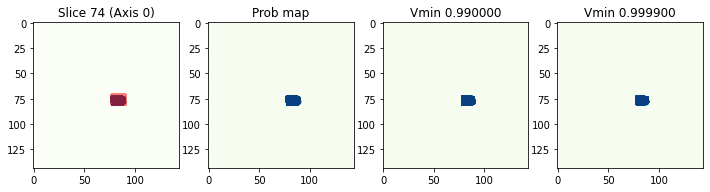

prob max 1.0 vmins:  0.99 0.9999


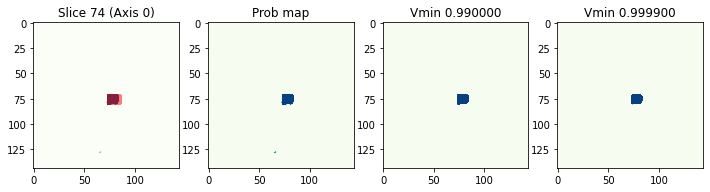

prob max 1.0 vmins:  0.99 0.9999


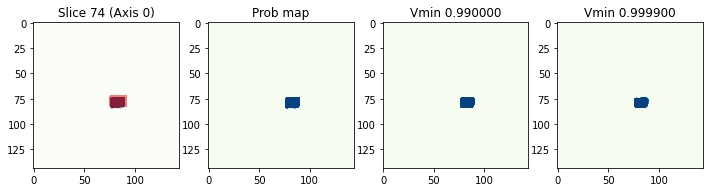

prob max 1.0 vmins:  0.99 0.9999


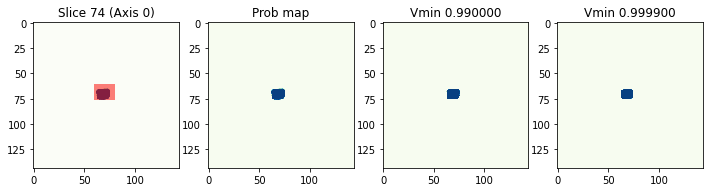

prob max 1.0 vmins:  0.99 0.9999


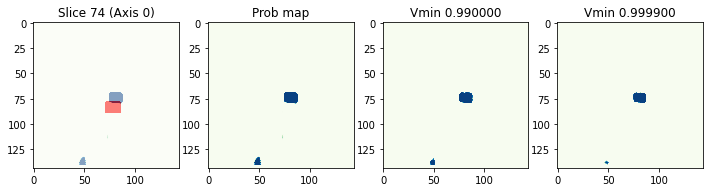

prob max 1.0 vmins:  0.99 0.9999


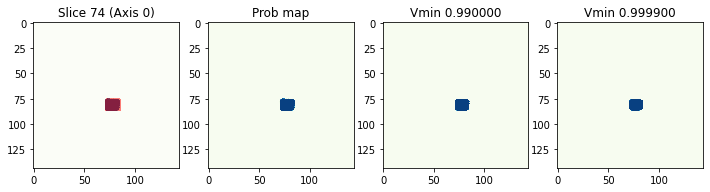

prob max 1.0 vmins:  0.99 0.9999


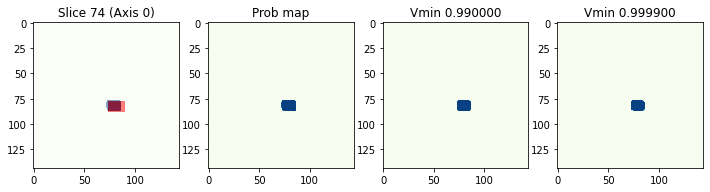

prob max 1.0 vmins:  0.99 0.9999


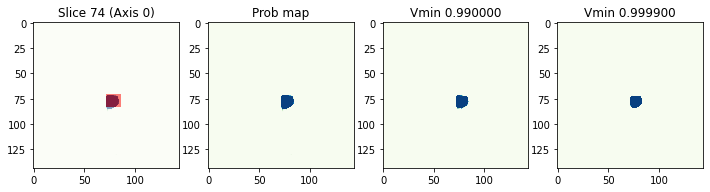

prob max 1.0 vmins:  0.99 0.9999


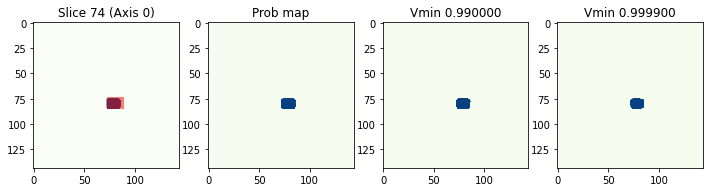

prob max 1.0 vmins:  0.99 0.9999


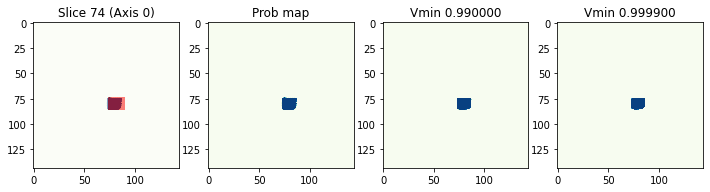

prob max 1.0 vmins:  0.99 0.9999


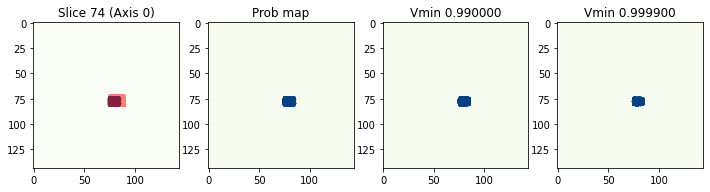

prob max 1.0 vmins:  0.99 0.9999


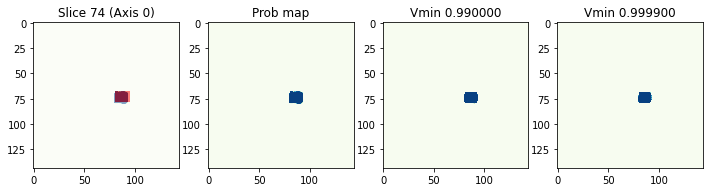

prob max 1.0 vmins:  0.99 0.9999


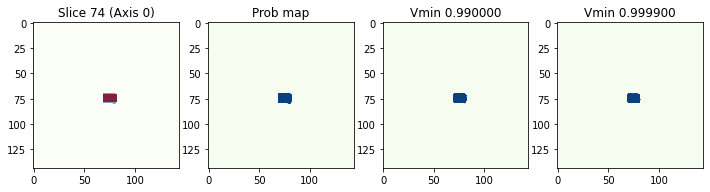

prob max 1.0 vmins:  0.99 0.9999


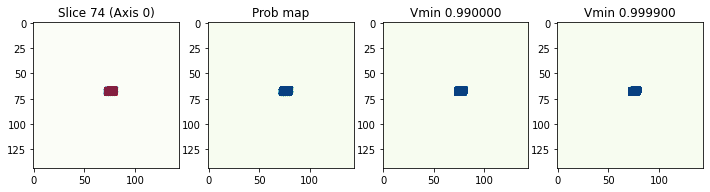

prob max 1.0 vmins:  0.99 0.9999


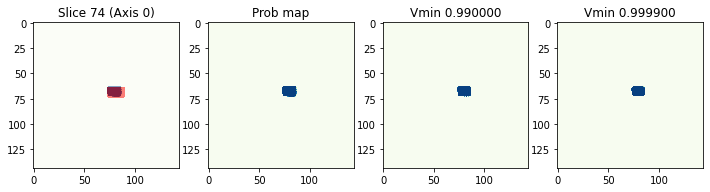

prob max 1.0 vmins:  0.99 0.9999


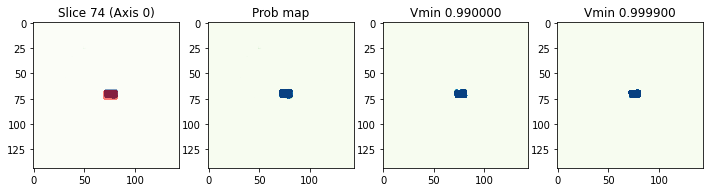

prob max 1.0 vmins:  0.99 0.9999


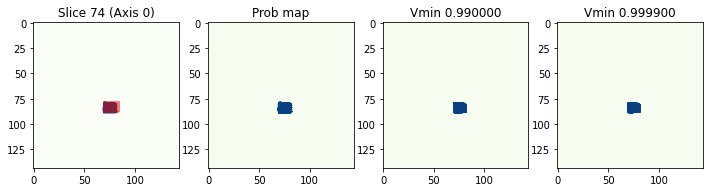

prob max 1.0 vmins:  0.99 0.9999


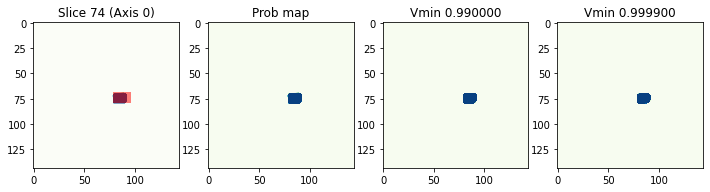

prob max 1.0 vmins:  0.99 0.9999


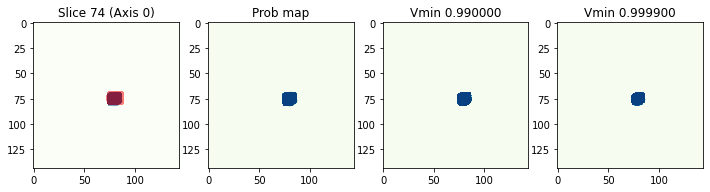

prob max 1.0 vmins:  0.99 0.9999


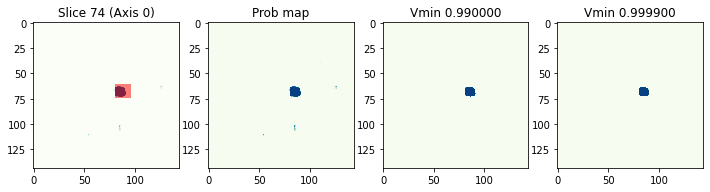

In [60]:
prob_cmap  = "GnBu" #"hot" https://matplotlib.org/stable/tutorials/colors/colormaps.html 
bin_cmap2  = colors.ListedColormap(['white', 'red'])

for sorted_idx in sorted_idxs:

    pred_bbox = sorted_pred_bboxs[sorted_idx]
    prob_map  = sorted_pred_probs[sorted_idx]
    mr        = sorted_mrs[sorted_idx].squeeze()

    axis_idx = 0
    slice_idx = 74

    # get prob slice
    prob_slice = np.take(np.asarray(prob_map), slice_idx, axis=axis_idx)

    # print min/max
    prob_max = np.max(prob_slice.reshape(-1,))

    vmin1 = min(0.99, prob_max)
    vmin2 = min(0.9999, prob_max)

    print("prob max", prob_max, "vmins: ", vmin1, vmin2)

    # get arr
    mr_slice = np.take(mr, slice_idx, axis=axis_idx)

    # rotate
    prob_slice = np.rot90(prob_slice)
    mr_slice = np.rot90(mr_slice)

    # plot: MR + probmap, probmap, probmap > 0.99
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,12))

    axes[0].set_title(f"Slice {slice_idx} (Axis {axis_idx})")
    axes[1].set_title(f"Prob map")
    axes[2].set_title(f"Vmin {vmin1:.6f}")
    axes[3].set_title(f"Vmin {vmin2:.6f}")


    # plot probability map
    axes[0].imshow(mr_slice, cmap=bin_cmap2) #plt.cm.gray
    axes[0].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest', alpha=0.5)

    probcolor1 = axes[1].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest')
    probcolor2 = axes[2].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest', vmin=vmin1, vmax=1.)
    probcolor3 = axes[3].imshow(prob_slice, cmap=prob_cmap, interpolation='nearest', vmin=vmin2, vmax=1.)

    #fig.colorbar()
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(probcolor, cax=cbar_ax)
    plt.show()

n 109 vs  20736


Text(0.5, 1.0, 'Distr. Prob(vox=sella)')

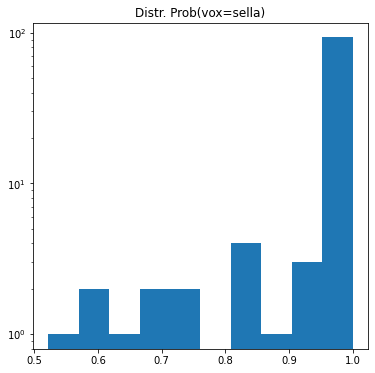

In [61]:
# filter probs > 0.1

thresh = 0.50

probs_flat = prob_slice.reshape(-1,)
probs_eps = probs_flat[probs_flat>thresh]
print("n", len(probs_eps), "vs ", len(probs_flat))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

ax.hist(probs_eps)
ax.set_yscale('log')
ax.set_title("Distr. Prob(vox=sella)")

In [ ]:
sorted_idx = 8

pred_bbox = sorted_pred_bboxs[sorted_idx]
prob_map  = sorted_pred_probs[sorted_idx]
mr        = sorted_mrs[sorted_idx].squeeze()

# plot all slices
nslices = np.sum([pred_bbox[2*i+1]-pred_bbox[2*i] for i in range(3)])
ncols = 4
nrows = 3 #nslices - nslices//ncols

print(f"nslices {nslices} nrows {nrows} ncols {ncols}")

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))

# take slice
row = 0
col = 0

for axis_idx in range(3):
    slice_start, slice_end = pred_bbox[2*axis_idx], pred_bbox[2*axis_idx+1]
    slice_mid = slice_start + (slice_end-slice_start)//2
    slice_start, slice_end = slice_mid-2, slice_mid+2
    
    for slice_idx in range(slice_start, slice_end):
        axes[row,col].set_title(f"Slice {slice_idx} (Axis {axis_idx})")

        # get prob slice
        prob_slice = np.take(np.asarray(prob_map), slice_idx, axis=axis_idx)
        
        # get arr
        mr_slice = np.take(mr, slice_idx, axis=axis_idx)
        
        # plot probability map
        axes[row,col].imshow(mr_slice)
        axes[row,col].imshow(prob_slice, cmap='hot', interpolation='nearest', alpha=0.5)
        
        # update row, col
        col += 1
        if col % ncols == 0: 
            row += 1
            col = 0
            
#fig.colorbar()            
plt.show()

# Viz heatmap probs 13

In [69]:
probs = predictions.softmax(1)[:,1]
print(f"Probs", probs.shape)

Probs torch.Size([30, 144, 144, 144])


TypeError: Invalid shape (144, 144, 144) for image data

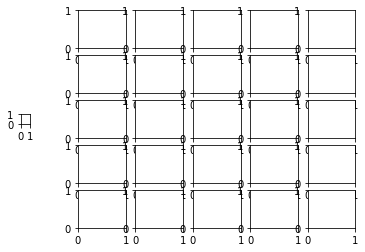

In [70]:
fig, ax = plt.subplots(nrows=5, ncols=6)

for i in range(30):
    plt.subplot(1,30,i+1)
    plt.imshow(probs[i], cmap='hot', interpolation='nearest')

plt.show()

# Viz

In [58]:
# Viz

def viz_bbox_unlbl(mr, pred, axis_fn0 = np.rot90, axis_fn1 = np.rot90, axis_fn2 = np.rot90, save_src = None):
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, pred_mk = np.array(mr), np.array(pred_mk)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
 
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = pred_mk,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*pred_bbox[0:2]), fixed_axis=0, \
            axis_fn = axis_fn0, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = pred_mk,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b = lrange(*pred_bbox[2:4]), fixed_axis_b=1, \
            axis_fn_b = axis_fn1,
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = pred_mk,     color1_c = "yellow",  alpha1_c=0.3, \
            slices_c = lrange(*pred_bbox[4:6]), fixed_axis_c=2, \
            axis_fn_c = axis_fn2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2, save_src=save_src)


# Test

Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 3830/MPRAGE/2012-06-18_11_46_49.0/S341930/las_corrected_n4.nii
Pred: 
Bbox coords: (59, 45, 61) to (80, 87, 78). Size: 21, 42, 17.
Bounding box coord: from location (45, 61) of slice 59 to location (87, 78) of slice 80.


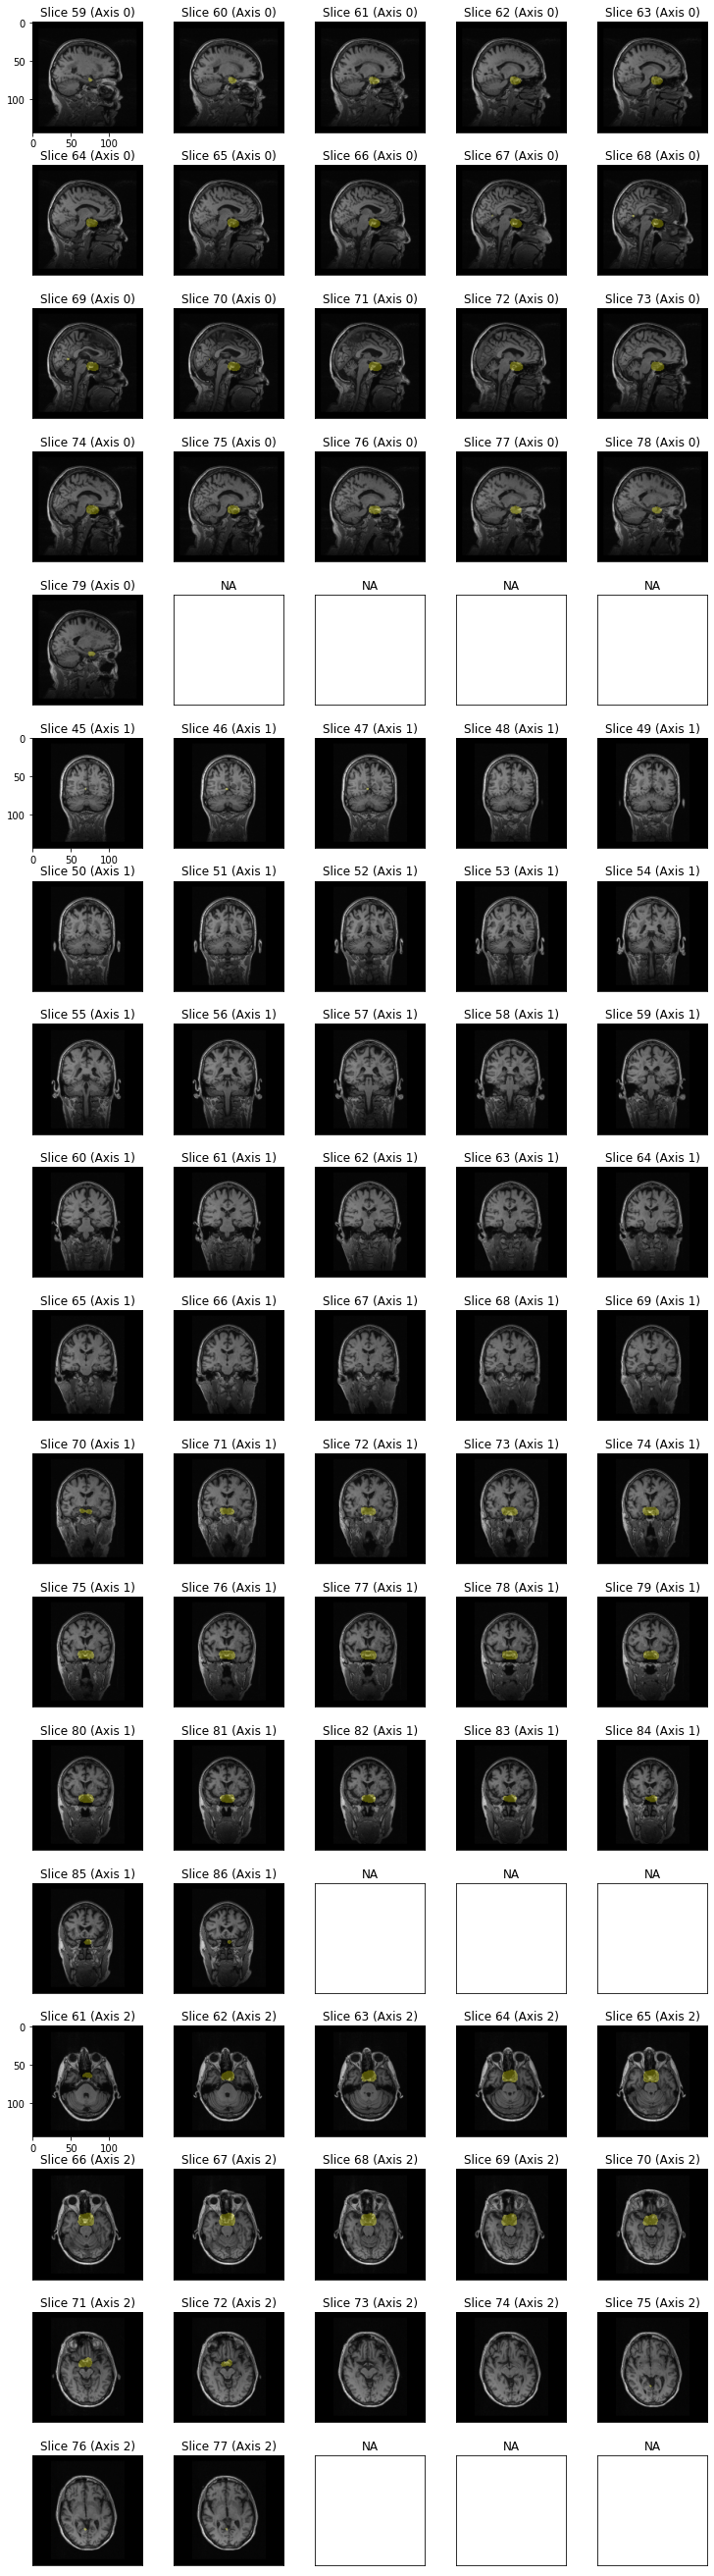

In [59]:
idx  = 0
pred = predictions[idx]
mr   = targets[idx].squeeze()

print("Idx", idx, "Pred ", pred.shape, "MR ", mr.shape, "fn", items[idx][0][len(label_src):])

viz_bbox_unlbl(mr, pred)


In [60]:
# make dir
run_src = f"{data_src}/runs"
fig_src = f"{run_src}/{model_name}/figs"
pic_src = f"{fig_src}/{dset_name}"

print(pic_src)
Path(pic_src).mkdir(parents=True, exist_ok=True)

/gpfs/data/oermannlab/private_data/DeepPit/runs/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384969_Thu_Jul_07_2021_hr_17_min_36/figs/ABVIB


In [61]:
os.listdir(small_fnames[0])

['ABVIB_3830_MR_MPRAGE_br_raw_20160107123045680_4_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123344814_103_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123507768_21_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123537871_137_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123458294_106_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123051515_56_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123429266_128_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123043812_157_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123257438_163_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123522928_115_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123042324_148_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123523841_57_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_20160107123227313_176_S341930_I592538.dcm',
 'ABVIB_3830_MR_MPRAGE_br_raw_2016010712305

In [62]:
import glob

subset_sz = 4

for dset_name in dset_dict.keys():
    print(dset_name)
    
    # save loc
    pic_src = f"{fig_src}/{dset_name}"
    print(pic_src)
    Path(pic_src).mkdir(parents=True, exist_ok=True)

    # get items
    with open(f"{dsetmd_src}/{dset_name}_fnames.txt", "rb") as f:
        cross_dset_fnames = pickle.load(f)

    small_fnames = cross_dset_fnames[:subset_sz]

    las_niis = [f for mr_dir in small_fnames for f in glob.glob(f"{mr_dir}/*las_corrected_n4.nii")]    
    las_items = [(a,None) for a in las_niis]
    print("LAS items", len(las_items))

    items = las_items
    
    # dataloader
    tls = TfmdLists(items, item_tfms)
    dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)
    dls = dls.cuda()

    # model
    learn = Learner(dls   = dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

    # load model fname w/o .pth extension
    learn.load(f"{model_src}/{model_fn[:-4]}")

    # predict
    start = time.time()
    predictions, targets = learn.get_preds(dl=dls.train)
    elapsed = time.time() - start

    print(f"Elapsed: {elapsed:0.2f} s for {len(items)} items.")

    for idx in range(len(predictions)):
        pred = predictions[idx]
        mr   = targets[idx].squeeze()

        print("Idx", idx, "Pred ", pred.shape, "MR ", mr.shape, "fn", items[idx][0][len(label_src):])

        viz_bbox_unlbl(mr, pred, save_src=f"{pic_src}/idx_{idx}.png")

ABIDE
/gpfs/data/oermannlab/private_data/DeepPit/runs/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384969_Thu_Jul_07_2021_hr_17_min_36/figs/ABIDE
LAS items 4


Elapsed: 1.05 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 1/50383/MP-RAGE/2000-01-01_00_00_00.0/S164289/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 69, 18) to (81, 94, 67). Size: 18, 25, 49.
Bounding box coord: from location (69, 18) of slice 63 to location (94, 67) of slice 81.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 1/50412/MP-RAGE/2000-01-01_00_00_00.0/S164292/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 69, 18) to (81, 94, 67). Size: 18, 25, 49.
Bounding box coord: from location (69, 18) of slice 63 to location (94, 67) of slice 81.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 1/50407/MP-RAGE/2000-01-01_00_00_00.0/S164294/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 69, 18) to (81, 94, 67). Size: 18, 25, 49.
Bounding box coord: from location (69, 18) of slice 63 to location (94, 67) of slice 81.
Idx 3 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 1

Elapsed: 0.93 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 3830/MPRAGE/2012-06-18_11_46_49.0/S341930/las_corrected_n4.nii
Pred: 
Bbox coords: (59, 45, 22) to (81, 87, 78). Size: 22, 42, 56.
Bounding box coord: from location (45, 22) of slice 59 to location (87, 78) of slice 81.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 7036/T1_SPGR/2011-08-10_12_32_48.0/S354724/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 64, 22) to (86, 92, 95). Size: 23, 28, 73.
Bounding box coord: from location (64, 22) of slice 63 to location (92, 95) of slice 86.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 263/MPRAGE/2011-11-15_11_26_09.0/S343566/las_corrected_n4.nii
Pred: 
Bbox coords: (64, 51, 27) to (83, 87, 76). Size: 19, 36, 49.
Bounding box coord: from location (51, 27) of slice 64 to location (87, 76) of slice 83.
Idx 3 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn

Elapsed: 0.82 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn omplete_1Yr_1.5T/ADNI/023_S_0139/MPR-R__GradWarp__B1_Correction__N3__Scaled/2007-02-09_09_44_27.0/S26343/las_corrected_n4.nii
Pred: 
Bbox coords: (62, 61, 39) to (85, 85, 64). Size: 23, 24, 25.
Bounding box coord: from location (61, 39) of slice 62 to location (85, 64) of slice 85.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn omplete_1Yr_1.5T/ADNI/023_S_0139/MPR__GradWarp__B1_Correction__N3__Scaled_2/2006-07-28_14_03_25.0/S17401/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 60, 20) to (83, 87, 76). Size: 20, 27, 56.
Bounding box coord: from location (60, 20) of slice 63 to location (87, 76) of slice 83.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn omplete_1Yr_1.5T/ADNI/023_S_0139/MPR__GradWarp__B1_Correction__N3__Scaled_2/2006-01-24_11_12_57.0/S11079/las_corrected_n4.nii
Pred: 
Bbox coords: (62, 61, 39) to (82, 83, 

Elapsed: 0.94 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 8/MPRAGE_SAG_ISO_p2_ND/2012-10-06_11_32_11.0/S231118/las_corrected_n4.nii
Pred: 
Bbox coords: (64, 63, 16) to (83, 96, 77). Size: 19, 33, 61.
Bounding box coord: from location (63, 16) of slice 64 to location (96, 77) of slice 83.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 3/MPRAGE_ADNI_confirmed/2011-09-17_11_44_55.0/S169142/las_corrected_n4.nii
Pred: 
Bbox coords: (64, 49, 47) to (81, 81, 88). Size: 17, 32, 41.
Bounding box coord: from location (49, 47) of slice 64 to location (81, 88) of slice 81.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 3/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_corrected_n4.nii
Pred: 
Bbox coords: (64, 51, 25) to (83, 77, 78). Size: 19, 26, 53.
Bounding box coord: from location (51, 25) of slice 64 to location (77, 78) of slice 83.
Idx 3 Pred  torch.Size([2, 144, 144, 144]) 

Elapsed: 1.07 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn HC_1098/MPRAGE_T1_AX_0.8_mm_TI-780/2009-03-13_13_01_09.0/S68959/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 64, 46) to (82, 80, 58). Size: 19, 16, 12.
Bounding box coord: from location (64, 46) of slice 63 to location (80, 58) of slice 82.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn HC_1098/MPRAGE_T1_AX_0.8_mm_TI-766/2009-03-13_13_01_09.0/S68954/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 63, 46) to (82, 80, 58). Size: 19, 17, 12.
Bounding box coord: from location (63, 46) of slice 63 to location (80, 58) of slice 82.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn HC_1098/MPRAGE_T1_AX_0.8_mm_TI-773/2009-03-13_13_01_09.0/S68955/las_corrected_n4.nii
Pred: 
Bbox coords: (63, 63, 46) to (81, 79, 58). Size: 18, 16, 12.
Bounding box coord: from location (63, 46) of slice 63 to location (79, 58) of slice 81.
Idx 3 Pred 

Elapsed: 1.03 s for 4 items.
Idx 0 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 05/MPRAGEadni/2010-12-23_10_50_52.0/S189286/las_corrected_n4.nii
Pred: 
Bbox coords: (61, 62, 69) to (81, 79, 82). Size: 20, 17, 13.
Bounding box coord: from location (62, 69) of slice 61 to location (79, 82) of slice 81.
Idx 1 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 19/MPRAGE_GRAPPA/2013-05-30_14_05_04.0/S214288/las_corrected_n4.nii
Pred: 
Bbox coords: (49, 36, 22) to (86, 82, 65). Size: 37, 46, 43.
Bounding box coord: from location (36, 22) of slice 49 to location (82, 65) of slice 86.
Idx 2 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([144, 144, 144]) fn 29/MPRAGE_GRAPPA_ADNI/2016-10-18_14_14_19.0/S606272/las_corrected_n4.nii
Pred: 
Bbox coords: (62, 45, 19) to (82, 88, 76). Size: 20, 43, 57.
Bounding box coord: from location (45, 19) of slice 62 to location (88, 76) of slice 82.
Idx 3 Pred  torch.Size([2, 144, 144, 144]) MR  torch.Size([1

# Reorient

In [142]:
# ABIDE: (1, 0, 0, 0, -1, 0, 0, 0, 1) 
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(np.array([1., 0., 0., 0., -1., 0., 0., 0., 1.])))
print(sitk.DICOMOrientImageFilter_GetOrientationFromDirectionCosines(np.ravel(np.eye(3))))

LAS
LPS


# Items LAS

In [82]:
las_niis  = [f"{fn}/las_corrected_n4.nii" for fn in cross_dset_fnames if "las_corrected_n4.nii" in os.listdir(fn)]
print(len(las_niis))

las_items = [(a,None) for a in las_niis]
print("LAS items", len(las_items))

small_las_items = las_items[:30]
print("Small subset LAS items", len(small_las_items))

1300
LAS items 1300
Small subset LAS items 30


# Dataloaders LAS

In [83]:
# time it
start = time.time()

# tls
las_tls = TfmdLists(small_las_items, item_tfms)

# dls
las_dls = las_tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers, drop_last=False)

# GPU
las_dls = las_dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(small_las_items)} items")

Elapsed time: 0.3614318370819092 s for 30 items


In [84]:
gc.collect()

248807

In [85]:
las_learn = Learner(dls   = las_dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [86]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
las_predictions, las_targets = las_learn.get_preds(dl=las_dls.train)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(small_las_items)} items.")

print("Pred mask", las_predictions.shape, "Target (x = y = MR)", las_targets.shape)
print("Pred mask", las_predictions[0].shape, "Target", las_targets[0].shape)

Elapsed: 4.68 s for 30 items.
Pred mask torch.Size([30, 2, 144, 144, 144]) Target (x = y = MR) torch.Size([30, 1, 144, 144, 144])
Pred mask torch.Size([2, 144, 144, 144]) Target torch.Size([1, 144, 144, 144])


# Viz LAS

LAS Pred  torch.Size([2, 144, 144, 144]) LAS MR  torch.Size([144, 144, 144])
Pred: 
Bbox coords: (63, 49, 21) to (82, 87, 80). Size: 19, 38, 59.
Bounding box coord: from location (49, 21) of slice 63 to location (87, 80) of slice 82.


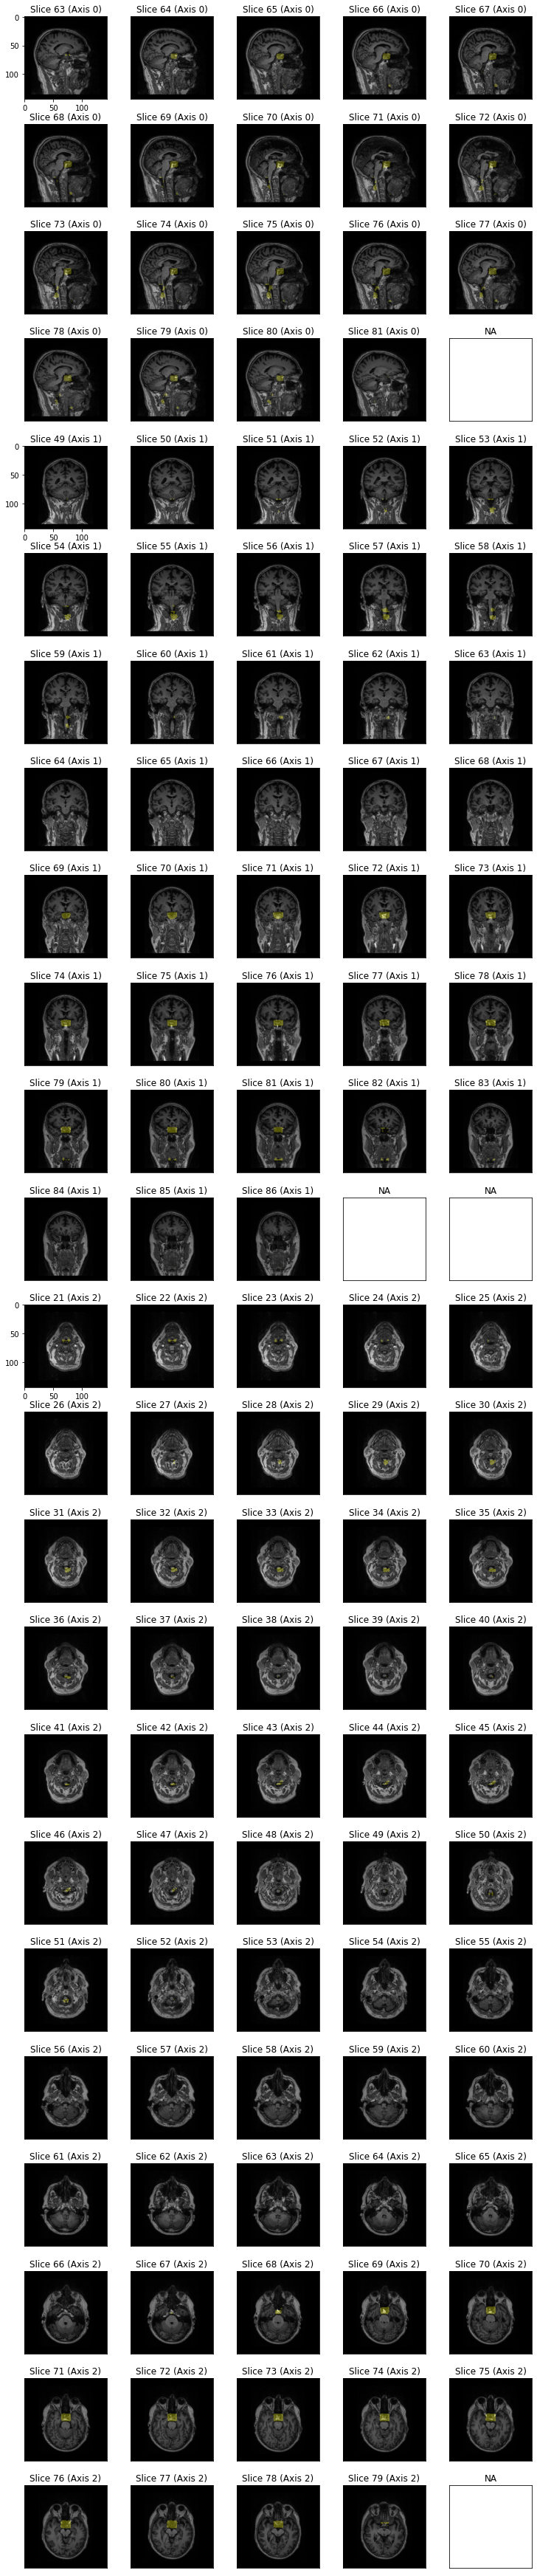

In [87]:
idx = 10
las_pred = las_predictions[idx]
las_mr   = las_targets[idx].squeeze()

print("LAS Pred ", las_pred.shape, "LAS MR ", las_mr.shape)

viz_bbox_unlbl(las_mr, las_pred)

# Viz las

In [ ]:
from matplotlib import gridspec

def plot_mid_slices(x, y, ax, no_ticks=True):
    bbox = mask2bbox(y)
    mids = get_mid_idx(bbox)
    for i in range(3):
        ax[i].imshow(np.rot90(np.take(x, mids[i], axis=i)), cmap=plt.cm.gray)
        ax[i].imshow(np.rot90(np.take(y, mids[i], axis=i)), alpha=0.50)
        
        if no_ticks:
            ax[i].set_xticks([])
            ax[i].set_yticks([])

def get_gridspec(nrows, ncols, wspace=0.0, hspace=0.0, fig_mult=1.):
    fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
    gs  = gridspec.GridSpec(nrows, ncols,
    wspace=wspace, hspace=hspace, 
    top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
    left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    return fig, gs
    
def viz_compare_aug(batch, aug, n=5):
    # original MR, seg
    x,y = get_batch_item(batch)

    # compare to aug MR, seg
    fig, gs = get_gridspec(nrows=3, ncols=1+n)
    axes = np.array([[plt.subplot(gs[row,col]) for col in range(1+n)] for row in range(3)])
    
    #_, axes = plt.subplots(nrows=3, ncols=1+n, figsize=(12,12))
    
    plot_mid_slices(x,y, axes[:,0], no_ticks=False)
        
    # compare to aug MR, seg
    for i in range(1,n+1):
        aug_batch = aug(batch) 
        aug_x, aug_y = get_batch_item(aug_batch)
        plot_mid_slices(aug_x, aug_y, axes[:,i], no_ticks=True)
    plt.plot()

In [64]:
# xb,yb = learn.dls.one_batch()
# init_loss = learn.loss_func(learn.model(xb), yb)
# print(init_loss)

# a = learn.model(xb)
# print(a.shape)

# overall_dice = dice_score(predictions, targets)
# print(overall_dice)

# Test set: Prediction Dice Distribution

In [21]:
indiv_dices = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fab296d0eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fab296e4438>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fab29718630>],
 'medians': [<matplotlib.lines.Line2D at 0x7fab296e49e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fab296e4cc0>],
 'means': []}

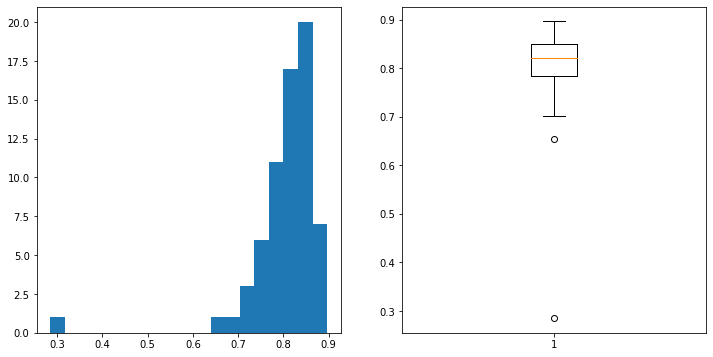

In [22]:
np_indiv_dices = np.array([t.item() for t in indiv_dices])
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

In [23]:
# num dices under 0.6
threshold = 0.6
low_dice_idxs, low_dices = zip(*[(i,dice) for i,dice in enumerate(indiv_dices) if dice < threshold])

In [24]:
print(len(low_dices), low_dice_idxs, [indiv_dices[i] for i in low_dice_idxs])

1 (60,) [tensor(0.2857)]


# $\Delta$ bbox

In [25]:
print(predictions.shape, predictions[0].shape, targets[0].shape, torch.argmax(predictions[0], dim=0).shape)

torch.Size([67, 2, 144, 144, 144]) torch.Size([2, 144, 144, 144]) torch.Size([1, 144, 144, 144]) torch.Size([144, 144, 144])


In [26]:
gt_bboxs   = [mask2bbox(np.asarray(targets[i].squeeze()))                for i in range(len(targets))]
pred_bboxs = [mask2bbox(np.asarray(torch.argmax(predictions[i], dim=0))) for i in range(len(predictions))]

In [27]:
print(gt_bboxs[0], pred_bboxs[0])

(64, 83, 67, 80, 51, 61) (64, 83, 65, 82, 50, 63)


In [28]:
# compare sizes
def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax): return imax - imin, jmax-jmin, kmax-kmin
gt_bbox_szs   = [get_bbox_size(*gt) for gt in gt_bboxs]
pred_bbox_szs = [get_bbox_size(*pr) for pr in pred_bboxs]

In [29]:
import pandas as pd
gt_df = pd.DataFrame(gt_bbox_szs, columns =['i', 'j', 'k'])
pred_df = pd.DataFrame(pred_bbox_szs, columns =['i', 'j', 'k'])

In [30]:
gt_bbox_szs

[(19, 13, 10),
 (18, 14, 12),
 (15, 15, 9),
 (18, 14, 10),
 (13, 16, 9),
 (18, 18, 11),
 (17, 15, 11),
 (15, 12, 9),
 (16, 13, 12),
 (16, 15, 9),
 (19, 12, 8),
 (18, 13, 11),
 (15, 16, 10),
 (17, 13, 12),
 (17, 17, 10),
 (15, 13, 10),
 (21, 16, 9),
 (15, 12, 10),
 (18, 15, 14),
 (17, 16, 12),
 (15, 10, 9),
 (16, 13, 10),
 (18, 14, 11),
 (17, 15, 11),
 (17, 13, 12),
 (18, 13, 13),
 (16, 15, 12),
 (15, 12, 10),
 (17, 18, 12),
 (15, 13, 11),
 (16, 13, 10),
 (18, 16, 11),
 (14, 17, 11),
 (15, 12, 8),
 (16, 13, 11),
 (16, 16, 10),
 (17, 16, 10),
 (15, 14, 7),
 (17, 15, 11),
 (16, 17, 11),
 (18, 15, 10),
 (18, 13, 12),
 (18, 16, 9),
 (16, 13, 9),
 (18, 14, 14),
 (14, 10, 10),
 (20, 16, 11),
 (16, 14, 12),
 (17, 13, 10),
 (16, 16, 12),
 (18, 16, 10),
 (18, 15, 13),
 (16, 12, 9),
 (19, 16, 11),
 (18, 11, 13),
 (15, 12, 10),
 (18, 14, 10),
 (15, 11, 11),
 (15, 13, 9),
 (16, 14, 11),
 (93, 14, 12),
 (12, 15, 9),
 (14, 15, 11),
 (15, 14, 11),
 (18, 14, 10),
 (18, 15, 9),
 (13, 14, 7)]

In [31]:
pred_bbox_szs

[(19, 17, 13),
 (18, 14, 14),
 (17, 15, 13),
 (18, 16, 15),
 (19, 15, 13),
 (19, 18, 11),
 (18, 15, 14),
 (17, 13, 11),
 (20, 16, 13),
 (19, 17, 11),
 (19, 17, 13),
 (18, 16, 16),
 (17, 15, 13),
 (21, 15, 13),
 (18, 17, 13),
 (19, 15, 12),
 (18, 15, 12),
 (19, 16, 13),
 (20, 17, 13),
 (19, 16, 14),
 (15, 12, 11),
 (17, 13, 11),
 (19, 15, 11),
 (18, 17, 14),
 (18, 15, 13),
 (19, 17, 14),
 (20, 38, 41),
 (18, 14, 12),
 (17, 16, 12),
 (20, 40, 17),
 (18, 16, 13),
 (18, 15, 13),
 (20, 18, 15),
 (16, 14, 11),
 (18, 49, 16),
 (18, 16, 13),
 (18, 20, 15),
 (18, 15, 15),
 (17, 16, 13),
 (18, 17, 12),
 (18, 15, 13),
 (17, 50, 19),
 (17, 24, 13),
 (17, 15, 14),
 (18, 16, 14),
 (16, 14, 11),
 (21, 16, 12),
 (19, 16, 13),
 (18, 16, 13),
 (20, 17, 13),
 (19, 17, 13),
 (18, 15, 13),
 (25, 20, 14),
 (18, 18, 13),
 (17, 16, 13),
 (18, 15, 13),
 (23, 21, 20),
 (35, 29, 43),
 (17, 16, 15),
 (18, 15, 12),
 (19, 18, 14),
 (18, 17, 15),
 (17, 16, 12),
 (18, 20, 15),
 (21, 19, 13),
 (20, 16, 15),
 (16, 14, 

<AxesSubplot:>

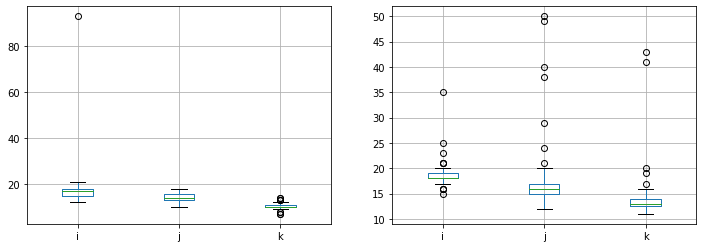

In [32]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
gt_df.boxplot(column=['i', 'j', 'k'],   ax=axes[0])
pred_df.boxplot(column=['i', 'j', 'k'], ax = axes[1])

In [33]:
print(list(pred_bbox_szs[i] for i in low_dice_idxs))

[(19, 18, 14)]


array([<AxesSubplot:title={'center':'i'}>,
       <AxesSubplot:title={'center':'j'}>,
       <AxesSubplot:title={'center':'k'}>], dtype=object)

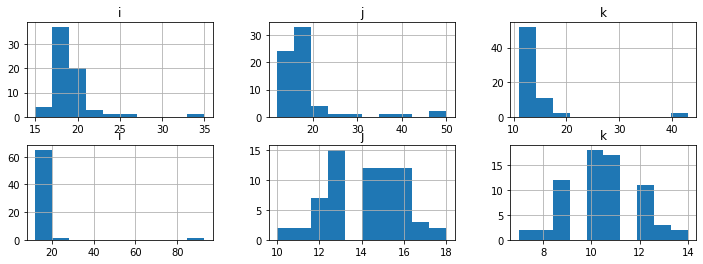

In [34]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))
pred_df.hist(column=['i', 'j', 'k'], ax=axes[0])
gt_df.hist(column=['i', 'j', 'k'], ax=axes[1])

In [35]:
def bbox_missing(gt_bbox, pred_bbox):
    # for i_min: missing if gt < pred
    # for i_max: missing if gt > pred
    mins = [max(pred_bbox[i] - gt_bbox[i], 0) for i in (0, 2, 4)]
    maxs = [max(gt_bbox[i] - pred_bbox[i], 0) for i in (1, 3, 5)]
    missing = [x for t in zip(mins, maxs) for x in t]
    return missing

In [36]:
# test
print(bbox_missing((0,1,2,3,4,5), (0,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (1,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (-2,2,2,3,4,5)))

[0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]


In [37]:
missings = [bbox_missing(gt, pred) for gt, pred in zip(gt_bboxs, pred_bboxs)]

In [38]:
missings_df = pd.DataFrame(missings, columns =['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

<AxesSubplot:>

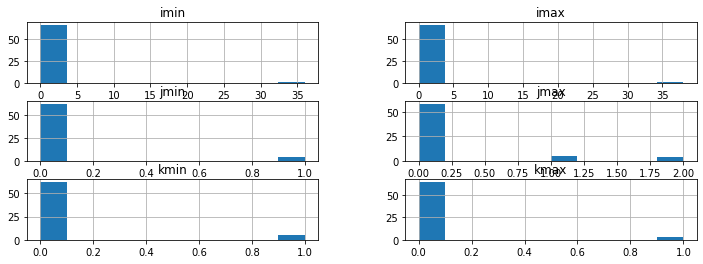

In [39]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

missings_df.hist(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[0])
missings_df.boxplot(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[1])

In [40]:
for col in ['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax']:
    nonzero = [v for v in missings_df[col].values if v != 0]
    max_nonzero = max(nonzero) if len(nonzero) > 0 else "NA"
    print(f"{col}: n = {len(nonzero)}, max diff = {max_nonzero}")

imin: n = 3, max diff = 36
imax: n = 8, max diff = 38
jmin: n = 5, max diff = 1
jmax: n = 9, max diff = 2
kmin: n = 5, max diff = 1
kmax: n = 3, max diff = 1


# Viz best, worst

In [41]:
worst_idx = np.argmin(np_indiv_dices)
best_idx  = np.argmax(np_indiv_dices)
print("Worst. Idx = ", worst_idx, "Dice: ", np_indiv_dices[worst_idx])
print("Best. Idx = ", best_idx, "Dice: ", np_indiv_dices[best_idx])

Worst. Idx =  60 Dice:  0.28568315505981445
Best. Idx =  34 Dice:  0.8963545560836792


# Worst

fname: ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50132/MP-RAGE/2000-01-01_00_00_00.0/S165256/ABIDE_50132_MRI_MP-RAGE_br_raw_20120830221747048_S165256_I329266_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50132/seg.pt')
Worst mr and seg shape:  torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Pred, target shape:  torch.Size([2, 144, 144, 144]) torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Check that target == train_ds[worst_idx] True
GT bbox (29, 122, 78, 92, 54, 66)
GT bbox and Pred bbox:  (29, 122, 78, 92, 54, 66) (65, 84, 77, 95, 54, 68)
Pred: 
Bbox coords: (65, 77, 54) to (84, 95, 68). Size: 19, 18, 14.
Bounding box coord: from location (77, 54) of slice 65 to location (95, 68) of slice 84.
GT: 
Bbox coords: (29, 78, 54) to (122, 92, 66). Size: 93, 14, 12.
Bounding box coord: from location (78, 54) of slice 29 to location (92, 66) of slice 122.
Union: 
Bbox coords: (29, 77, 54)

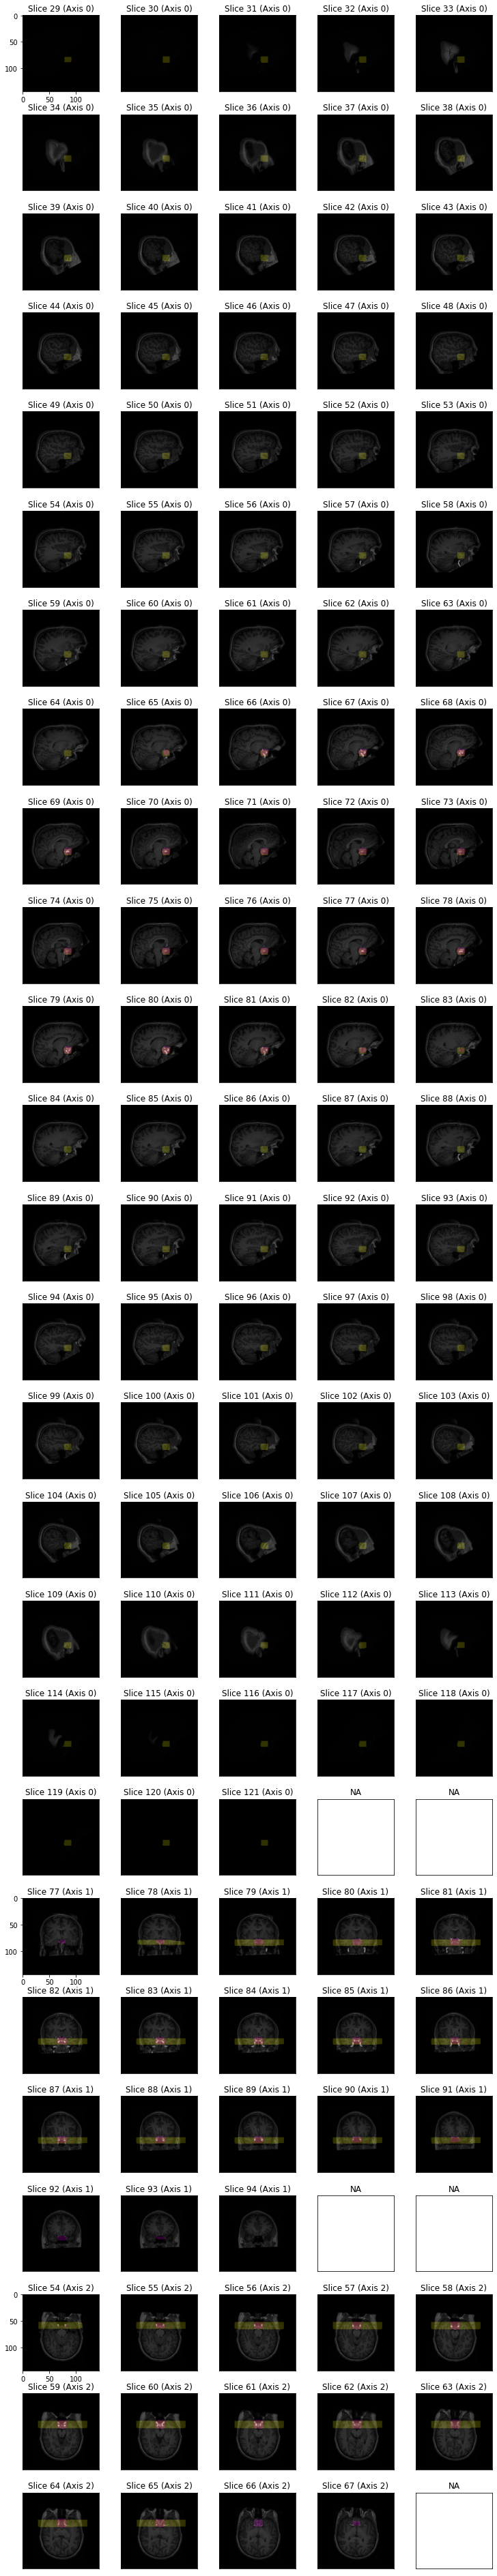

In [42]:
print(f"fname: {test_items[worst_idx]}")

worst_mr, worst_seg = tls[worst_idx]
print(f"Worst mr and seg shape: ", worst_mr.shape, worst_seg.shape)

pred, target = predictions[worst_idx], targets[worst_idx].squeeze()

#pred = torch.argmax(predictions[worst_idx], dim=0)
print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[worst_idx][0].shape)
print("Check that target == train_ds[worst_idx]", np.array_equal(dls.train_ds[worst_idx][1], target))

mr = dls.train_ds[worst_idx][0]
print("GT bbox", mask2bbox(np.asarray(target)))
print("GT bbox and Pred bbox: ", gt_bboxs[worst_idx], pred_bboxs[worst_idx])

viz_compare_outputs(mr, target, pred)

# Best

fname: ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50182/MP-RAGE/2000-01-01_00_00_00.0/S164570/ABIDE_50182_MRI_MP-RAGE_br_raw_20120830170756014_S164570_I328573_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212/50182/seg.pt')
Best mr and seg shape:  torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Pred, target shape:  torch.Size([2, 144, 144, 144]) torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Check that target == train_ds[best_idx] True
GT bbox (65, 81, 76, 89, 64, 75)
GT bbox and Pred bbox:  (65, 81, 76, 89, 64, 75) (64, 82, 42, 91, 63, 79)
Pred: 
Bbox coords: (64, 42, 63) to (82, 91, 79). Size: 18, 49, 16.
Bounding box coord: from location (42, 63) of slice 64 to location (91, 79) of slice 82.
GT: 
Bbox coords: (65, 76, 64) to (81, 89, 75). Size: 16, 13, 11.
Bounding box coord: from location (76, 64) of slice 65 to location (89, 75) of slice 81.
Union: 
Bbox coords: (64, 42, 63) to (8

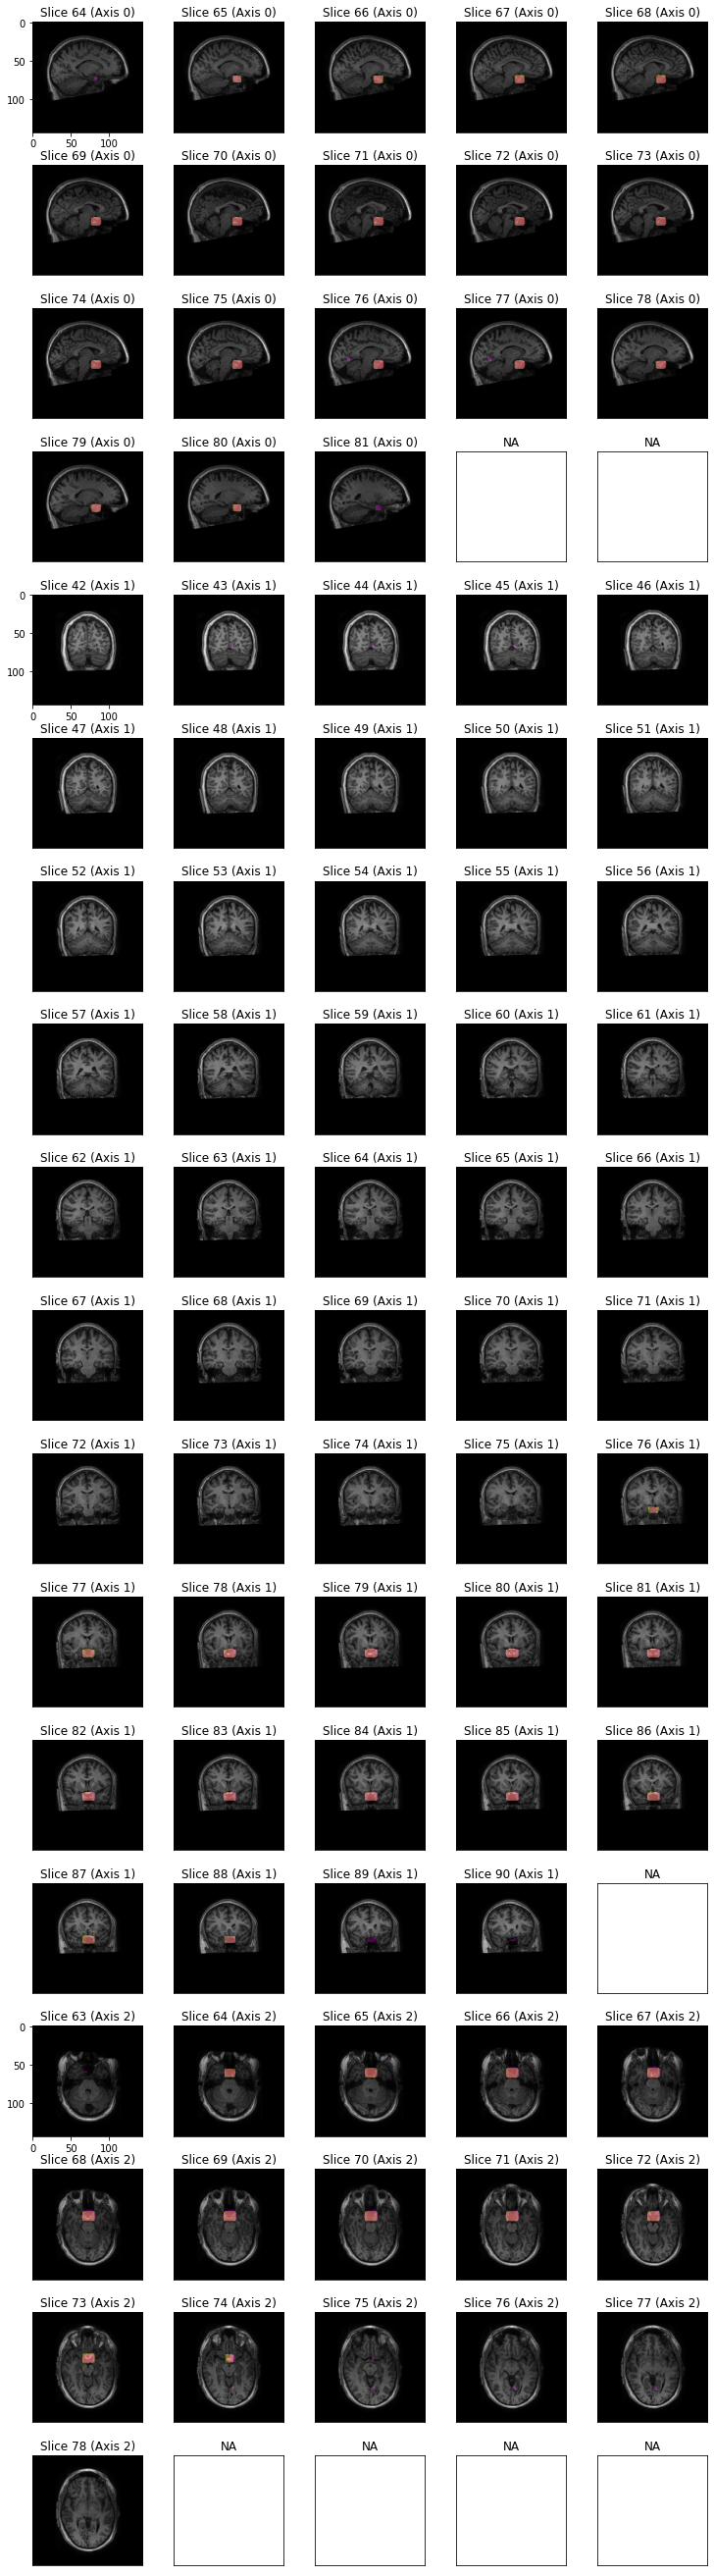

In [43]:
print(f"fname: {test_items[best_idx]}")

best_mr, best_seg = tls[best_idx]
print(f"Best mr and seg shape: ", best_mr.shape, best_seg.shape)

pred, target = predictions[best_idx], targets[best_idx].squeeze()

#pred = torch.argmax(predictions[worst_idx], dim=0)
print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[best_idx][0].shape)
print("Check that target == train_ds[best_idx]", np.array_equal(dls.train_ds[best_idx][1], target))

mr = dls.train_ds[best_idx][0]
print("GT bbox", mask2bbox(np.asarray(target)))
print("GT bbox and Pred bbox: ", gt_bboxs[best_idx], pred_bboxs[best_idx])

viz_compare_outputs(mr, target, pred)

In [44]:
# 30 sec for 67 test items (2 CPU workers)
learn.validate(ds_idx=0)

(#2) [0.021809542551636696,0.8051332235336304]

# Resize Pred

In [45]:
# pad to new size
class ReverseTfm(ItemTransform):
    split_idx = None
    
    def __init__(self, iso_sz, const_sz):
        self.iso_sz   = iso_sz
        self.const_sz = const_sz
    
    def encodes(self, item):
        
        # decode item
        pred, im_path = item
        
        # Get shape post-Iso
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)

        # iso resize
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.iso_sz)) for osz,ospc in zip(orig_sz, orig_sp)]
        
        # Pads used to go from iso_sz => const_sz
        pad = [x-y for x,y in zip(self.const_sz, new_sz)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        # Undo pad: const_sz => new_sz
        shape0, shape1, shape2 = pred.shape
        a,b,c,d,e,f            = pad
        pred_no_pad = pred[e:shape0-f, c:shape1-d, a:shape2-b]

        # Undo iso (add batch dim for interpolate)
        while pred_no_pad.ndim < 5: 
            pred_no_pad = pred_no_pad.unsqueeze(0)
            
        return F.interpolate(pred_no_pad.float(), size = orig_sz, mode = 'nearest').squeeze().long()


In [46]:
pred = predictions[0]
pred_mk   = torch.argmax(pred, dim=0)
nii = test_items[0][0]

print(pred_mk.shape, nii, sep="\n")

torch.Size([144, 144, 144])
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50316/MP-RAGE/2000-01-01_00_00_00.0/S164316/ABIDE_50316_MRI_MP-RAGE_br_raw_20120830150611958_S164316_I328310_corrected_n4.nii


In [47]:
im_path, segm_path = test_items[0]
orig_mk = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()

RTfm = ReverseTfm(iso_sz = iso_sz, const_sz = maxs)
rev_pred = RTfm((pred_mk, nii))
print(f"Orig mask shape: {orig_mk.shape}, Reversed Iso({iso_sz} shape: {rev_pred.shape})")
print("Orig mask", mask2bbox(np.asarray(orig_mk)))
print("Pred mask", mask2bbox(np.asarray(rev_pred)))

Orig mask shape: torch.Size([256, 256, 124]), Reversed Iso(2 shape: torch.Size([256, 256, 124]))
Orig mask (112, 148, 117, 143, 26, 42)
Pred mask (113, 150, 115, 148, 26, 47)


# Predict unlabelled

In [ ]:
ds = "ABIDE"
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

# load ABIDE files
with open(f"{deepPit_src}/saved_metadata/{ds}.txt", "rb") as input_file:
    ABIDE_fns = pickle.load(input_file)
    
# change prefix path
def change_src(overlap, s, new_src):
    return new_src + s[s.index(overlap) + len(overlap):]

ABIDE_fns = [change_src("PitMRdata", s, data_src) for s in ABIDE_fns]

# ABIDE ABIDE
ABIDE_ABIDE_fns = [fn for fn in ABIDE_fns if fn.startswith(f"{data_src}/ABIDE/ABIDE")]
print(f"ABIDE: {len(ABIDE_fns)} vs {len(ABIDE_ABIDE_fns)} files for ABIDE/ABIDE.")

# Get unlabelled files
def get_folder_name(s): 
    return re.search('\/([0-9]{5})\/', s).group(1)

ABIDE_folders = [get_folder_name(s) for s in ABIDE_ABIDE_fns]
labelled_folders = [child for folder in os.listdir(label_src) for child in os.listdir(f"{label_src}/{folder}")]
unlabelled_fns = [fn for fn in ABIDE_ABIDE_fns if get_folder_name(fn) not in labelled_folders]

# filter to exclude Matched_bandwidth_hires?
print(*unlabelled_fns[0:10], sep="\n")
print(os.listdir(unlabelled_fns[0])), print(os.listdir(unlabelled_fns[1]))

# unlabelled .nii files
unlabelled_items = [f"{fn}/{os.listdir(fn)[0]}" for fn in unlabelled_fns if "MP-RAGE" in fn]
print(len(unlabelled_items))

#unlabelled_folders = [folder for folder in ABIDE_folders if folder not in labelled_folders]
#print(f"Unlabelled_folders: {len(unlabelled_folders)}")

In [ ]:
class IsoTestSet(Transform):
    
    def __init__(self, new_sp = 3):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path = x
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
        im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
       
        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        while im.ndim < 5: 
            im = im.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze()
    
class Unsqueeze(Transform):
    def encodes(self, x):
        return x.unsqueeze(1) #.unsqueeze(0)

In [ ]:
print(test_items[0]) 
print(unlabelled_items[0])

In [ ]:
# test DLs (no labelled segm obj)

unlabelled_items_subset = unlabelled_items[0:30]
unlabelled_items_subset = [(a,a) for a in unlabelled_items_subset]

unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
unlbl_tls = TfmdLists(unlabelled_items_subset, unlbl_tfms)
unlbl_dls = unlbl_tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# e

# unlbl_tfms = [IsoTestSet(3), PadSz(maxs)]
# unlbl_dl = TfmdDL(Datasets(unlabelled_items_subset), \
#                   after_item=unlbl_tfms, \
#                   after_batch=AddChannel(), \
#                   bs=bs, num_workers=num_workers)

# #dl = TfmdDL(Datasets(torch.arange(50), tfms = [L(), [_Add1()]]))
# unlbl_dls = DataLoaders(unlbl_dl, unlbl_dl)

# tls       = TfmdLists(unlabelled_items, test_tfms)
# test_dls = tls.dataloaders(bs=bs, after_batch=AddChannel(), num_workers=num_workers)

# test get one batch
b = unlbl_dls.one_batch()
print(type(b), len(b), b[0].shape, b[1].shape)
print(len(unlbl_dls.train_ds), len(unlbl_dls.valid_ds))

In [ ]:
# all predictions, 36

full_res = maxs

unlbl_learn = Learner(dls=unlbl_dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= loss, \
                metrics = dice_score)

# load model fname w/o .pth extension
unlbl_learn.load(f"{model_src}/{model_fn[:-4]}")

In [ ]:
learn.predict??

In [ ]:
is_cat,_,probs = unlbl_learn.predict(unlabelled_items_subset[0])

In [ ]:
learn.predict()

In [ ]:
unlbl_learn.get_preds??

In [ ]:
unlbl_predictions = unlbl_learn.get_preds(dl=unlbl_dl)[0]
print(unlbl_predictions.shape)

In [ ]:
# Viz

def viz_bbox_unlbl(idx):
    mr = unlbl_learn.dls.train_ds[idx][0] 
    pred = unlbl_predictions[idx]
    
    # convert pred to mask
    pred_mk   = torch.argmax(pred, dim=0)
    pred_bbox = mask2bbox(np.array(pred_mk))

    mr, pred_mk = np.array(mr), np.array(pred_mk)
    
    # print bbox
    print("Pred: "); print_bbox(*pred_bbox)
 
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = pred_mk,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*pred_bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = pred_mk,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b = lrange(*pred_bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = pred_mk,     color1_c = "yellow",  alpha1_c=0.3, \
            slices_c = lrange(*pred_bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


In [ ]:
viz_bbox_unlbl(0)

# Unlablled items

In [58]:
dset_name =  "ABIDE" #"ADNI1_Complete_1Yr_1.5T" #"AIBL" #"ABVIB" #"ICMB" # "AIBL" # "ABVIB"
dset_src  = dset_dict[dset_name]

In [59]:
# metadata
with open(f"{dsetmd_src}/ABIDE_dset_metadata.pkl", "rb") as f:
    a = pickle.load(f)
    print("ABIDE Orientations: ", set(a.dir.values.tolist()))

# metadata
with open(f"{dsetmd_src}/{dset_name}_dset_metadata.pkl", "rb") as f:
    a = pickle.load(f)
    print(f"{dset_name} Orientations: ", set(a.dir.values.tolist()))
    
# load files
with open(f"{dsetmd_src}/{dset_name}_dset_metadata.pkl", "rb") as f:
    q_t1 = pickle.load(f)

with open(f"{dsetmd_src}/{dset_name}_fnames.txt", "rb") as f:
    cross_dset_fnames = pickle.load(f)

print(f"{dset_name}, n = {len(cross_dset_fnames)}") #, *fnames, sep="\n")

ABIDE Orientations:  {(1, 0, 0, 0, -1, 0, 0, 0, 1)}
ABIDE Orientations:  {(1, 0, 0, 0, -1, 0, 0, 0, 1)}
ABIDE, n = 1157


In [60]:
small_fnames = cross_dset_fnames[:30]

niis  = [f"{fn}/corrected_n4.nii" for fn in small_fnames]
items = [(a,None) for a in niis]
print(len(items), items[0])

30 ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/ABIDE/ABIDE_1/50383/MP-RAGE/2000-01-01_00_00_00.0/S164289/corrected_n4.nii', None)


In [61]:
las_niis  = [f"{fn}/las_corrected_n4.nii" for fn in cross_dset_fnames if "las_corrected_n4.nii" in os.listdir(fn)]
print(len(las_niis))

las_items = [(a,None) for a in las_niis]
print("LAS items", len(las_items))

small_las_items = las_items[:30]
print("Small subset LAS items", len(small_las_items))

items = small_las_items

1157
LAS items 1157
Small subset LAS items 30
